In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tarfile
import os
import csv
import shutil

In [2]:
# Download Oxford 17 Category Flower Dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz -O 17flowers.tgz

--2022-10-26 03:08:01--  http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz [following]
--2022-10-26 03:08:01--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  96.3MB/s    in 0.6s    

2022-10-26 03:08:02 (96.3 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]



In [3]:
file = tarfile.open("17flowers.tgz")
file.extractall("data_flowers/")
dir = "data_flowers/jpg/"
arr = os.listdir(dir)

# uncomment this if you just download a new flower17 dataset
# otherwise, you don't need to remove this file again
os.remove("data_flowers/jpg/files.txt") # this file is useless

In [4]:
with open('flowers.csv', mode = "w") as f:
  f.truncate()
with open('flowers.csv', mode='a', newline='') as f:
  csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_writer.writerow(list(np.array(["img_id", "classes"])))

dir = "data_flowers/jpg/"
arr = os.listdir(dir)
arr.sort
n = 0
for img in arr:
  if img[:6] == "image_":
    img_id = img[:-4]
    id = img[6:-4]
    id.lstrip('0')
    id = int(id)
    if (id%80 != 0):
      label = (id//80)+1
    else:
      label = id//80
    row = list(np.array([img_id, label]))

    # Export to CSV
    with open('flowers.csv', mode='a', newline='') as f:
      csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      csv_writer.writerow(row)

In [5]:
# data frame
df = pd.read_csv("flowers.csv")

# attribute for our images
df = df[['img_id', 'classes']]

In [6]:
!mkdir data

In [7]:
%cd data

/content/data


In [8]:
# make folder for each class
!mkdir {f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17}

In [9]:
# separate images to each class folder
for i, (_, i_row) in enumerate(df.iterrows()):
  file_class = i_row['classes']
  file_name = i_row['img_id'] + ".jpg"
  file_path = "/content/data_flowers/jpg/" + i_row['img_id'] + ".jpg"
  shutil.copyfile(file_path, 'f' + str(file_class) + "/" + file_name)

In [10]:
%cd ..

/content


In [11]:
# Build the ResNet50 model
def get_model():
    model = torchvision.models.alexnet(weights=None)

    model.fc = nn.Linear(2048, 17)
    return model

In [ ]:
model = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
print(model)

In [12]:
# Build the transformer for the dataset in training, validation and testing
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Build the dataset in training, validation and testing from ./jpg where the images are stored in 17 folders
train_dataset = torchvision.datasets.ImageFolder(root='./data', transform=transformer)

# Split the dataset into training, validation and testing
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

In [ ]:
# Set the batch size used for model training
batch_sizes =[4, 32, 64]

In [13]:
batch_sizes =[64]

In [14]:
# Define the training function and return loss
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function and return loss
def validate(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss

# Define the testing function and return accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

In [15]:
# Define the optimizer
def get_optimizer(model, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return optimizer

# Define the training process
def train_process(model, device, train_loader, valid_loader, optimizer, epochs, test_loader):
    train_loss = []
    valid_loss = []
    test_acc = []
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        valid_loss.append(validate(model, device, valid_loader))
        test_acc.append(test(model, device, test_loader))
    return train_loss, valid_loss, test_acc


In [16]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
# Start training and testing
train_losses = []
valid_losses = []
test_accs = []
i = 0
for batch_size in batch_sizes:
    print('Batch size: {}'.format(batch_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model = get_model()
    model = model.to(device)
    optimizer = get_optimizer(model, 0.001) # lr
    train_loss, valid_loss, test_acc = train_process(model, device, train_loader, val_loader, optimizer, 60, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_accs.append(test_acc)
    i += 1

Batch size: 64
Train Epoch: 1 [0/1088 (0%)]	Loss: 6.908364
Validation set: Average loss: 6.8971, Accuracy: 3/136 (2%)
Test set: Average loss: 6.8964, Accuracy: 3/136 (2%)
Train Epoch: 2 [0/1088 (0%)]	Loss: 6.896958
Validation set: Average loss: 6.8796, Accuracy: 6/136 (4%)
Test set: Average loss: 6.8792, Accuracy: 5/136 (4%)
Train Epoch: 3 [0/1088 (0%)]	Loss: 6.878712
Validation set: Average loss: 6.8585, Accuracy: 5/136 (4%)
Test set: Average loss: 6.8583, Accuracy: 4/136 (3%)
Train Epoch: 4 [0/1088 (0%)]	Loss: 6.860829
Validation set: Average loss: 6.8272, Accuracy: 8/136 (6%)
Test set: Average loss: 6.8277, Accuracy: 4/136 (3%)
Train Epoch: 5 [0/1088 (0%)]	Loss: 6.821767
Validation set: Average loss: 6.7464, Accuracy: 9/136 (7%)
Test set: Average loss: 6.7487, Accuracy: 8/136 (6%)
Train Epoch: 6 [0/1088 (0%)]	Loss: 6.725469
Validation set: Average loss: 5.6580, Accuracy: 9/136 (7%)
Test set: Average loss: 5.6852, Accuracy: 6/136 (4%)
Train Epoch: 7 [0/1088 (0%)]	Loss: 5.601702
Valid

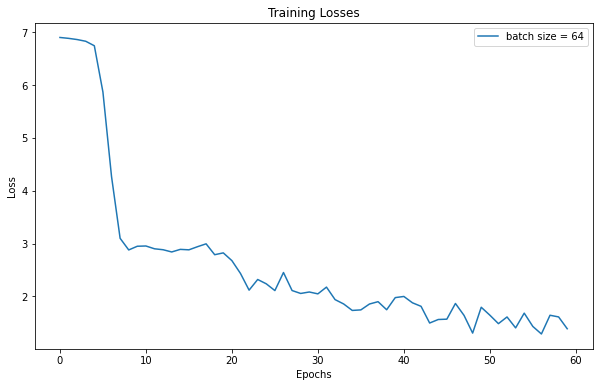

In [18]:
# Plot the training for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(train_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

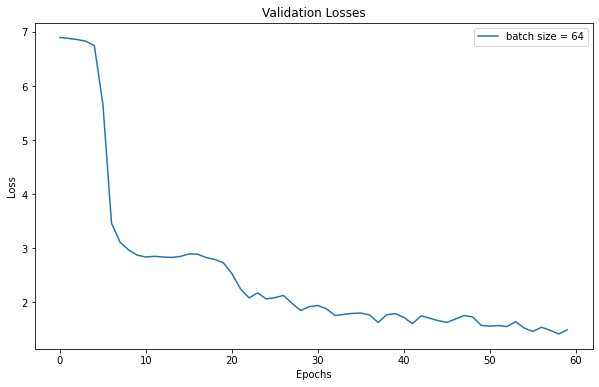

In [19]:
# Plot the validation for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(valid_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

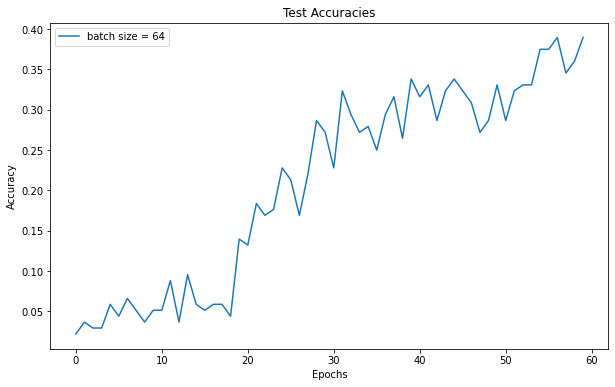

In [20]:
# Plot the test accuracy for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(test_accs[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracies')
plt.legend()

In [21]:
!mkdir AlexNet_result

In [22]:
# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_64': train_losses[0]})
valid_lossespd = pd.DataFrame({'batch_size_64': valid_losses[0]})
test_accspd = pd.DataFrame({'batch_size_64': test_accs[0]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./AlexNet_result/train_losses.csv', index=True)
valid_lossespd.to_csv('./AlexNet_result/valid_losses.csv', index=True)
test_accspd.to_csv('./AlexNet_result/test_accs.csv', index=True)

In [ ]:
# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_4': train_losses[0], 'batch_size_32': train_losses[1], 'batch_size_64': train_losses[2]})
valid_lossespd = pd.DataFrame({'batch_size_4': valid_losses[0], 'batch_size_32': valid_losses[1], 'batch_size_64': valid_losses[2]})
test_accspd = pd.DataFrame({'batch_size_4': test_accs[0], 'batch_size_32': test_accs[1], 'batch_size_64': test_accs[2]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./ResNet50_result/train_losses.csv', index=True)
valid_lossespd.to_csv('./ResNet50_result/valid_losses.csv', index=True)
test_accspd.to_csv('./ResNet50_result/test_accs.csv', index=True)

IndexError: ignored